In [35]:
# Import library
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import keras.utils as image
import tensorflow as tf
from PIL import Image
import os
import pathlib
import matplotlib.image as mpimg
import ibm_boto3
from ibm_botocore.client import Config, ClientError
import io

In [3]:
# Jumlah kelas
num_classes = 3

In [4]:
# Input gambar
input_size = (128, 128, 3)

In [5]:
# Arsitektur ResNet50
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Convolutional block 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Convolutional block 2
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Convolutional block 3
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Convolutional block 4
    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# Buat model
model = resnet(input_size, num_classes)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                             

2023-06-28 14:12:09.908121: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [7]:
# Menyusun model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Augmentasi data dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Akses dataset
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"fredy78971","key":"96c67889bc6e960f412f0995a4ce7852"}

import json

with open('/home/wsuser/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /home/wsuser/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/wsuser/.kaggle’: File exists


In [11]:
!pip install kaggle
import kaggle

!kaggle datasets download -d fredy78971/daging-resnet50 --unzip fredy78971/daging-resnet50

 89%|██████████████████████████████████▋    | 53.0M/59.5M [00:00<00:00, 113MB/s]
100%|███████████████████████████████████████| 59.5M/59.5M [00:00<00:00, 125MB/s]


In [12]:
# Direktori dataset
train_path = './dataset/train'
valid_path = './dataset/valid'

In [13]:
# Cek jumlah data
data_dir = pathlib.Path('./dataset')
print("Total gambar: ", end='')
print(len(list(data_dir.glob('*/*/*.jpg'))))
print("Total untuk train: ", end='')
print(len(list(data_dir.glob('train/*/*.jpg'))))
print("Total untuk validation: ", end='')
print(len(list(data_dir.glob('valid/*/*.jpg'))))

Total gambar: 2266
Total untuk train: 1815
Total untuk validation: 451


In [14]:
# Cek persebaran data train
train_path = './dataset/train'

number_label = {}
total_files = 0

# Hitung data dalam setiap folder
for label in os.listdir(train_path):
    label_path = os.path.join(train_path, label)
    if os.path.isdir(label_path):
        counting = len(os.listdir(label_path))
        number_label[label] = counting
        total_files += counting

print(f"Total data: {total_files}")

for label, count in number_label.items():
    print(f"Kelas {label}", end=f': {count}\n')

Total data: 1815
Kelas Setengah-Segar: 630
Kelas Segar: 675
Kelas Busuk: 510


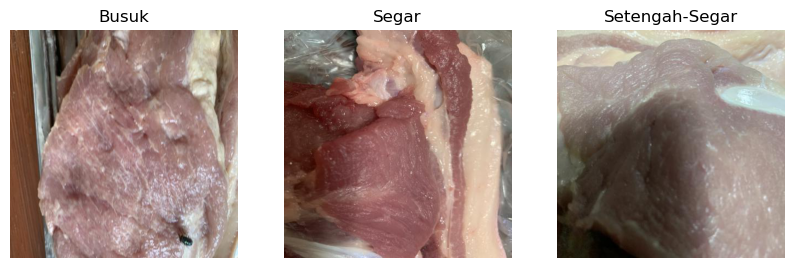

In [15]:
# Cek gambar setiap kelas
def display_images_from_each_class(class_folder_path):
    fig, axs = plt.subplots(1, len(os.listdir(class_folder_path)), figsize=(10, 4))

    for i, class_name in enumerate(sorted(os.listdir(class_folder_path))):
        class_path = os.path.join(class_folder_path, class_name)
        img_file = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, img_file)

        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(class_name)

    plt.show()

class_folder = './dataset/train'
display_images_from_each_class(class_folder)

In [16]:
# Atur batch
batch_size = 32

# Buat train dan validasi dari data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=input_size[:2],
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=input_size[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 1815 images belonging to 3 classes.
Found 451 images belonging to 3 classes.


In [17]:
# Atur step dari train dan validasi
num_train_steps = len(train_generator)
num_valid_steps = len(valid_generator)

In [18]:
# Latih model
history = model.fit(train_generator,
                    steps_per_epoch=num_train_steps,
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=num_valid_steps)

Epoch 1/100


2023-06-28 14:13:46.394547: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-28 14:13:46.396018: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


57/57 [==============================] - 13s 180ms/step - loss: 1.0793 - accuracy: 0.3675 - val_loss: 1.0944 - val_accuracy: 0.4412
Epoch 2/100
57/57 [==============================] - 10s 174ms/step - loss: 0.9784 - accuracy: 0.4760 - val_loss: 1.1039 - val_accuracy: 0.4102
Epoch 3/100
57/57 [==============================] - 11s 190ms/step - loss: 0.8151 - accuracy: 0.5895 - val_loss: 0.9202 - val_accuracy: 0.5211
Epoch 4/100
57/57 [==============================] - 11s 188ms/step - loss: 0.7388 - accuracy: 0.6242 - val_loss: 0.8057 - val_accuracy: 0.5920
Epoch 5/100
57/57 [==============================] - 11s 190ms/step - loss: 0.7259 - accuracy: 0.6364 - val_loss: 0.9023 - val_accuracy: 0.5876
Epoch 6/100
57/57 [==============================] - 11s 192ms/step - loss: 0.6556 - accuracy: 0.6766 - val_loss: 0.7953 - val_accuracy: 0.6364
Epoch 7/100
57/57 [==============================] - 11s 190ms/step - loss: 0.6270 - accuracy: 0.6931 - val_loss: 0.6971 - val_accuracy: 0.6763
Epoc

57/57 [==============================] - 11s 192ms/step - loss: 0.1079 - accuracy: 0.9609 - val_loss: 0.2418 - val_accuracy: 0.9024
Epoch 58/100
57/57 [==============================] - 11s 185ms/step - loss: 0.0999 - accuracy: 0.9636 - val_loss: 0.1441 - val_accuracy: 0.9534
Epoch 59/100
57/57 [==============================] - 11s 191ms/step - loss: 0.1071 - accuracy: 0.9587 - val_loss: 0.1760 - val_accuracy: 0.9446
Epoch 60/100
57/57 [==============================] - 11s 190ms/step - loss: 0.1024 - accuracy: 0.9647 - val_loss: 0.1507 - val_accuracy: 0.9401
Epoch 61/100
57/57 [==============================] - 11s 192ms/step - loss: 0.0776 - accuracy: 0.9736 - val_loss: 0.1799 - val_accuracy: 0.9268
Epoch 62/100
57/57 [==============================] - 11s 188ms/step - loss: 0.1033 - accuracy: 0.9647 - val_loss: 0.3991 - val_accuracy: 0.8625
Epoch 63/100
57/57 [==============================] - 11s 187ms/step - loss: 0.1238 - accuracy: 0.9543 - val_loss: 0.1635 - val_accuracy: 0.940

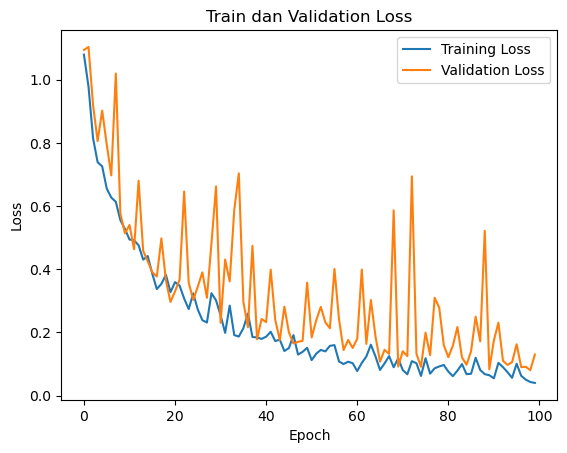

In [20]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

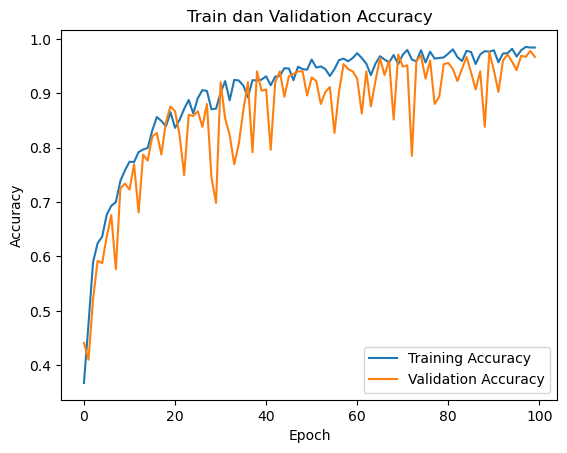

In [21]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Simpan model
model.save('model_resnet.h5')

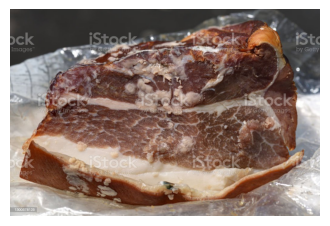

Hasil prediksi: Busuk
Persentase: 100.00%


In [56]:
# Siapkan model
model = load_model('model_resnet.h5')

# Preprocess gambar untuk uji model
img_path = './dataset/uji_coba/test2.jpg'
img = image.load_img(img_path, target_size=input_size[:2])
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Nama kelas
class_names = ['Busuk', 'Segar', 'Setengah Segar']

# Mendefinisikan tf.function untuk prediksi agar performa baik
@tf.function
def predict(image_array):
    return model(image_array)

# Buat prediksi dari gambar
predictions = predict(tf.convert_to_tensor(img_array))

# Ambil indeks hasil prediksi
predicted_class_index = np.argmax(predictions)

# Ambil kelas berdasarkan indeks
predicted_class_name = class_names[predicted_class_index]

# Ambil probabilitas untuk kelas hasil prediksi
predicted_probability = predictions[0][predicted_class_index]

predicted_accuracy = predicted_probability * 100

img = Image.open(img_path)

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(img)
ax.axis('off')
plt.show()

print("Hasil prediksi:", predicted_class_name)
print("Persentase: {:.2f}%".format(predicted_accuracy))

In [50]:
# Informasi terkait Cloud Object Storage
cos_credentials={
    "apikey": "bAdh2C6ZfmeFayl_TBN4AJx8YH5ce8l2665dnHpEYzuu",
    "cos_hmac_keys": {
        "access_key_id": "5c528b75007249bbb1a5079955b11c2d",
        "secret_access_key": "30b1a5e53a82e9cee1bb1bb321ccb65223718d4d70be5387"
    },
    "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
    "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/be2dc2b9319f48a293ebec49b1ec0fae:7d87ca4d-9f85-4a2a-a796-c0c9ef8102ca:resource-key:5c528b75-0072-49bb-b1a5-079955b11c2d",
    "iam_apikey_name": "WDP-Editor-daging-donotdelete-pr-pxuddgt3bpuz9a",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/be2dc2b9319f48a293ebec49b1ec0fae::serviceid:ServiceId-93223b5b-84c7-45b4-9f16-dd9549e23466",
    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/be2dc2b9319f48a293ebec49b1ec0fae:7d87ca4d-9f85-4a2a-a796-c0c9ef8102ca::"
}

auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.private.us-south.cloud-object-storage.appdomain.cloud'

In [51]:
# Buat client
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [54]:
# Fungsi untuk upload file ke Cloud Object Storage
def upload_file(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = os.path.basename(file_name)
    s3_client = cos
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [55]:
# Upload file model ke Cloud Object Storage
upload_file('./model_resnet.h5','daging-donotdelete-pr-pxuddgt3bpuz9a')

True